# Task 5: Topic Modeling

## Prepare Data




In [1]:
# Import Modules 

!pip install --update gensim # you may need to update gensim 
!pip install -q pyLDAvis # for visualization
!pip install --upgrade pandas==1.2 # need update colab pandas to version 1.2 so later visualization will work. 


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --update
     |████████████████████████████████| 1.7 MB 10.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 29.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [2]:
# The imports needed for this notebook
import numpy as np

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn import decomposition
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
nltk.download('punkt') 
# nltk.download('averaged_perceptron_tagger') 
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from string import punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

Mounted at /content/drive


In [4]:
# read a local csv file into Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mydata/review_tf_idf.csv", index_col = 0)
df.head(3)

,username,rating_x,date_of_review,review_content,rounded_rating,doctorID,Business ID,Name,Business Category,URL,snippet text,Address,City,State code,zip code,clamed,closed,latitude,longitude,phone_x,review_expanded,review_token,Potential_misspells,review_tagged,review_lemmas,review_norm,cleaned_review,Review_Length,unique_token,Cleaned_Review_Length,Lexical_Diversity,Count_Potential_Misspells,messageID,best,guy,check,!!!,many,year,always,recommend,team,thanks,doc,review,think,business,however,big,stop,care,...,client,response,rating_y,good,even,take,time,write,experience,address,bad,leave,much,high,make,issue,couple,real,ever,since,covid,medical,initial,appointment,staff,rude,find,practice,possible,information,phone_y,zero,compassion,try,end,conversation,thank,hope,day,hang,call,back,get,name,speak,office,manager,say,way,know,also,attitude,may,person,talk,set,schedule,email,ask,date,birth,cancel,kind,treatment,allow,see,forget,seriously,concern,health,anyone,field,anymore,side,note,respond,positive,door,great,doctor,never,show,minute,early,could,quickly,return,work,sign,sit,almost,two,hour,seem,admit,miss,file,add,short,next,another,watch,multiple,people,ahead,saw,want,order,test,need,first,week,later,would,three,month,ago,still,nothing,doctors,story,help,dad,tell,turn,like,stay,reschedule,meet,beyond,location,easy,clean,treat,respect,service,warm,patient,professional,extremely,knowledgeable,look,change,explain,negative,past,either,super,maybe,welcome,highly,sure,someone,long,wait,run,behind,mention,wear,require,one,awesome,face,surprise,non,soon,room,fill,decide,uncomfortable,car,ready,inside,inform,though,cost,bother,come,anything,reason,star,everything,else,knowledge,etc,actually,insurance,company,pay,man,pain,several,different,medicine,finally,able,figure,prescribe,right,feel,thankful,around,top,friendly,appt,felt,really,situation,prescription,refer,friend,immediately,comfortable,everyone,walk,compassionate,well,happy,book,simple,process,share,complaint,horrible,definitely,mother,perform,complete,procedure,mom,something,happen,let,hard,believe,cause,front,prior,surgery,place,guess,post,comment,bit,nervous,forever,arrive,mind,condition,base,type,question,along,plan,send,smile,receive,follow,appreciate,visit,give,hear,lady,away,unprofessional,cannot,answer,open,family,father,exam,thorough,far,expect,obviously,listen,medication,word,wonderful,bedside,manner,woman,desk,god,others,especially,poor,new,completely,husband,message,regard,specialist,special,plus,wrong,job,level,....,lobby,hospital,seek,yes,life,young,glass,wow,today,suck,yet,pretty,without,detail,suppose,history,previous,waste,truly,small,learn,quite,due,course,price,please,read,must,stick,honestly,switch,second,thing,twice,cancer,report,paper,use,hand,five,voice,full,claim,system,update,record,put,hold,contact,tech,assistant,keep,pleasant,bed,problem,skill,customer,elsewhere,lose,money,incompetent,till,state,pharmacy,pleased,instead,scan,request,wonder,ridiculous,busy,facility,save,heart,reach,age,primary,physician,consultation,online,bring,physical,pick,actual,efficient,nurse,consider,wife,part,remove,single,recovery,available,serious,quick,healthy,old,little,four,last,half,okay,fact,agree,unfortunately,case,understanding,lie,san,bill,provide,proper,sorry,handle,lunch,break,less,spend,anywhere,polite,courteous,area,worth,impressed,understand,choice,paperwork,min,least,notice,proceed,basically,drive,charge,point,billing,advise,member,honest,probably,every,helpful,nice,receptionist,surgeon,cold,together,pregnant,blood,pressure,clinic,apparently,already,start,water,grateful,child,sweet,informative,overall,trust,deliver,baby,emergency,necessary,waiting,result,chest,home,awful,move,labor,delivery,whole,amazing,ease,shot,remember,night,extra,offer,amaze,world,girl,matter,beautiful,floor,ultrasound,close,department,ray,within,machine,son,total,huge,avoid,stuff,literally,pass,straight,choose,number,loved,suffer,list,diagnose,school,include,sometimes,ignore,continue,longer

In [5]:
# final number of rows in the cleaned dataframe
print("final number of rows in the cleaned dataframe: ", len(df))

final number of rows in the cleaned dataframe:  62141


In [6]:
# Test to see if there was any empty reviews in the dataset
df['cleaned_review'].isnull().values.any()

False

### Check tokens have digits or punctuations and remove them

In [8]:
# tokenize 
df['review_token'] = df['cleaned_review'].apply(lambda row:wordpunct_tokenize(row))
df.head(3)

,username,rating_x,date_of_review,review_content,rounded_rating,doctorID,Business ID,Name,Business Category,URL,snippet text,Address,City,State code,zip code,clamed,closed,latitude,longitude,phone_x,review_expanded,review_token,Potential_misspells,review_tagged,review_lemmas,review_norm,cleaned_review,Review_Length,unique_token,Cleaned_Review_Length,Lexical_Diversity,Count_Potential_Misspells,messageID,best,guy,check,!!!,many,year,always,recommend,team,thanks,doc,review,think,business,however,big,stop,care,...,client,response,rating_y,good,even,take,time,write,experience,address,bad,leave,much,high,make,issue,couple,real,ever,since,covid,medical,initial,appointment,staff,rude,find,practice,possible,information,phone_y,zero,compassion,try,end,conversation,thank,hope,day,hang,call,back,get,name,speak,office,manager,say,way,know,also,attitude,may,person,talk,set,schedule,email,ask,date,birth,cancel,kind,treatment,allow,see,forget,seriously,concern,health,anyone,field,anymore,side,note,respond,positive,door,great,doctor,never,show,minute,early,could,quickly,return,work,sign,sit,almost,two,hour,seem,admit,miss,file,add,short,next,another,watch,multiple,people,ahead,saw,want,order,test,need,first,week,later,would,three,month,ago,still,nothing,doctors,story,help,dad,tell,turn,like,stay,reschedule,meet,beyond,location,easy,clean,treat,respect,service,warm,patient,professional,extremely,knowledgeable,look,change,explain,negative,past,either,super,maybe,welcome,highly,sure,someone,long,wait,run,behind,mention,wear,require,one,awesome,face,surprise,non,soon,room,fill,decide,uncomfortable,car,ready,inside,inform,though,cost,bother,come,anything,reason,star,everything,else,knowledge,etc,actually,insurance,company,pay,man,pain,several,different,medicine,finally,able,figure,prescribe,right,feel,thankful,around,top,friendly,appt,felt,really,situation,prescription,refer,friend,immediately,comfortable,everyone,walk,compassionate,well,happy,book,simple,process,share,complaint,horrible,definitely,mother,perform,complete,procedure,mom,something,happen,let,hard,believe,cause,front,prior,surgery,place,guess,post,comment,bit,nervous,forever,arrive,mind,condition,base,type,question,along,plan,send,smile,receive,follow,appreciate,visit,give,hear,lady,away,unprofessional,cannot,answer,open,family,father,exam,thorough,far,expect,obviously,listen,medication,word,wonderful,bedside,manner,woman,desk,god,others,especially,poor,new,completely,husband,message,regard,specialist,special,plus,wrong,job,level,....,lobby,hospital,seek,yes,life,young,glass,wow,today,suck,yet,pretty,without,detail,suppose,history,previous,waste,truly,small,learn,quite,due,course,price,please,read,must,stick,honestly,switch,second,thing,twice,cancer,report,paper,use,hand,five,voice,full,claim,system,update,record,put,hold,contact,tech,assistant,keep,pleasant,bed,problem,skill,customer,elsewhere,lose,money,incompetent,till,state,pharmacy,pleased,instead,scan,request,wonder,ridiculous,busy,facility,save,heart,reach,age,primary,physician,consultation,online,bring,physical,pick,actual,efficient,nurse,consider,wife,part,remove,single,recovery,available,serious,quick,healthy,old,little,four,last,half,okay,fact,agree,unfortunately,case,understanding,lie,san,bill,provide,proper,sorry,handle,lunch,break,less,spend,anywhere,polite,courteous,area,worth,impressed,understand,choice,paperwork,min,least,notice,proceed,basically,drive,charge,point,billing,advise,member,honest,probably,every,helpful,nice,receptionist,surgeon,cold,together,pregnant,blood,pressure,clinic,apparently,already,start,water,grateful,child,sweet,informative,overall,trust,deliver,baby,emergency,necessary,waiting,result,chest,home,awful,move,labor,delivery,whole,amazing,ease,shot,remember,night,extra,offer,amaze,world,girl,matter,beautiful,floor,ultrasound,close,department,ray,within,machine,son,total,huge,avoid,stuff,literally,pass,straight,choose,number,loved,suffer,list,diagnose,school,include,sometimes,ignore,continue,longer

In [9]:
# count the frequency of each unique token in the cleaned review
from nltk import FreqDist

# use FreqDis() to find the frequency disctibution for each token
%time fdist_reviews= FreqDist([token for sublist in df['review_token'].values for token in sublist])
print('The total number of tokens:',fdist_reviews.N())
print('The number of unique tokens:', len(fdist_reviews))

CPU times: user 2.37 s, sys: 5.34 ms, total: 2.37 s
Wall time: 2.39 s
The total number of tokens: 3405004
The number of unique tokens: 44044


In [10]:
# let's sort the items based on the frequency count
fdist_reviews_list = sorted(fdist_reviews.items(), key=lambda x:x[1], reverse= True)

In [11]:
# create a list of tokens
token_list = [token[0] for token in fdist_reviews_list]

In [12]:
# let's see if any tokens are not characters 
none_char_token = [token for token in token_list if all(j.isdigit() or j in string.punctuation for j in token)]

print(len(none_char_token))
print(*none_char_token)

897
... !!! .... !!!! ..... !!!!! ??? ...... !!!!!! ???? *** !!!!!!! !). ....... ?!?! "... ?!? --- ..." !!!!!!!! :-) **** ????? )... ?". !), ?). !?! $$$ ........ .). ?!! !!!!!!!!! ".... !.. ...." !". ".. !... ??!! !!!!!!!!!! ......... ?!!! .!! ?... .." ...( (?) ?!" !!) .!!! .". ?", !!" ).. ***** ...) ).... ?!?!? ,,, ?????? ??" ??! !!!) :). "). !!!" $$$. !!!!!!!!!!! $$. +++ ??) !?!? ?!) ?!?!?! !!.. ;-) !!. !!). ****** ..!! ??!!! "..... !!!. :// ..( ,,,, )!!! .*** .......... !!!!!!!!!!!!!! "!! ..., ...! .** )!! ???!!! ---- !!!!!!!!!!!!! $$$$ .., !.... "), ..! !!!!!!!!!!!! !!?? ...? "!!! ??????? !?" !?!?! :-( )..... ?), )." ,.. ....) ,... ...!!! ........... ???! !?? !??? ...). '... ???!! ?.... !!!??? ???????? !!!... :)! ............ ?.. !!, !!!!!!!!!!!!!!!!! !", ?!!!!! :)) ???" !!!!!!!!!!!!!!! "?? !!!' ___ )-- ----- ....( ............. ?!). """ !!!!. ."" !!!!" :-/ !!!!!!!!!!!!!!!!!!! ??!!!! .--- ?!?" ,..... ...". ???) ."... %... !*** !** ..? .), (???) ,,,,, :(. ?"" ....! .**** ...' ?!?? '

In [13]:
# let's create a cleaned set of tokens
df['review_cleaned_token'] = df['review_token'].apply(lambda row:[word for word in row if word not in none_char_token])
df.head(3)

,username,rating_x,date_of_review,review_content,rounded_rating,doctorID,Business ID,Name,Business Category,URL,snippet text,Address,City,State code,zip code,clamed,closed,latitude,longitude,phone_x,review_expanded,review_token,Potential_misspells,review_tagged,review_lemmas,review_norm,cleaned_review,Review_Length,unique_token,Cleaned_Review_Length,Lexical_Diversity,Count_Potential_Misspells,messageID,best,guy,check,!!!,many,year,always,recommend,team,thanks,doc,review,think,business,however,big,stop,care,...,client,response,rating_y,good,even,take,time,write,experience,address,bad,leave,much,high,make,issue,couple,real,ever,since,covid,medical,initial,appointment,staff,rude,find,practice,possible,information,phone_y,zero,compassion,try,end,conversation,thank,hope,day,hang,call,back,get,name,speak,office,manager,say,way,know,also,attitude,may,person,talk,set,schedule,email,ask,date,birth,cancel,kind,treatment,allow,see,forget,seriously,concern,health,anyone,field,anymore,side,note,respond,positive,door,great,doctor,never,show,minute,early,could,quickly,return,work,sign,sit,almost,two,hour,seem,admit,miss,file,add,short,next,another,watch,multiple,people,ahead,saw,want,order,test,need,first,week,later,would,three,month,ago,still,nothing,doctors,story,help,dad,tell,turn,like,stay,reschedule,meet,beyond,location,easy,clean,treat,respect,service,warm,patient,professional,extremely,knowledgeable,look,change,explain,negative,past,either,super,maybe,welcome,highly,sure,someone,long,wait,run,behind,mention,wear,require,one,awesome,face,surprise,non,soon,room,fill,decide,uncomfortable,car,ready,inside,inform,though,cost,bother,come,anything,reason,star,everything,else,knowledge,etc,actually,insurance,company,pay,man,pain,several,different,medicine,finally,able,figure,prescribe,right,feel,thankful,around,top,friendly,appt,felt,really,situation,prescription,refer,friend,immediately,comfortable,everyone,walk,compassionate,well,happy,book,simple,process,share,complaint,horrible,definitely,mother,perform,complete,procedure,mom,something,happen,let,hard,believe,cause,front,prior,surgery,place,guess,post,comment,bit,nervous,forever,arrive,mind,condition,base,type,question,along,plan,send,smile,receive,follow,appreciate,visit,give,hear,lady,away,unprofessional,cannot,answer,open,family,father,exam,thorough,far,expect,obviously,listen,medication,word,wonderful,bedside,manner,woman,desk,god,others,especially,poor,new,completely,husband,message,regard,specialist,special,plus,wrong,job,level,....,lobby,hospital,seek,yes,life,young,glass,wow,today,suck,yet,pretty,without,detail,suppose,history,previous,waste,truly,small,learn,quite,due,course,price,please,read,must,stick,honestly,switch,second,thing,twice,cancer,report,paper,use,hand,five,voice,full,claim,system,update,record,put,hold,contact,tech,assistant,keep,pleasant,bed,problem,skill,customer,elsewhere,lose,money,incompetent,till,state,pharmacy,pleased,instead,scan,request,wonder,ridiculous,busy,facility,save,heart,reach,age,primary,physician,consultation,online,bring,physical,pick,actual,efficient,nurse,consider,wife,part,remove,single,recovery,available,serious,quick,healthy,old,little,four,last,half,okay,fact,agree,unfortunately,case,understanding,lie,san,bill,provide,proper,sorry,handle,lunch,break,less,spend,anywhere,polite,courteous,area,worth,impressed,understand,choice,paperwork,min,least,notice,proceed,basically,drive,charge,point,billing,advise,member,honest,probably,every,helpful,nice,receptionist,surgeon,cold,together,pregnant,blood,pressure,clinic,apparently,already,start,water,grateful,child,sweet,informative,overall,trust,deliver,baby,emergency,necessary,waiting,result,chest,home,awful,move,labor,delivery,whole,amazing,ease,shot,remember,night,extra,offer,amaze,world,girl,matter,beautiful,floor,ultrasound,close,department,ray,within,machine,son,total,huge,avoid,stuff,literally,pass,straight,choose,number,loved,suffer,list,diagnose,school,include,sometimes,ignore,continue,longer

In [14]:
# repeat the process to see our current token list 
%time fdist_reviews= FreqDist([token for sublist in df['review_cleaned_token'].values for token in sublist])
print('The total number of tokens:',fdist_reviews.N())
print('The number of unique tokens:', len(fdist_reviews))

CPU times: user 2.22 s, sys: 9.56 ms, total: 2.23 s
Wall time: 2.24 s
The total number of tokens: 3376835
The number of unique tokens: 43147


In [15]:
# let's sort the items based on the frequency count
fdist_reviews_list = sorted(fdist_reviews.items(), key=lambda x:x[1], reverse= True)

In [16]:
# create a list of tokens
token_list = [token[0] for token in fdist_reviews_list]

In [17]:
# let's see if any tokens are not characters 
none_char_token = [token for token in token_list if all(j.isdigit() or j in string.punctuation for j in token)]

print(len(none_char_token))
print(*none_char_token)

0



In [18]:
# Test to see if there was any empty reviews in the dataset
df['review_cleaned_token'].isnull().values.any()

False

### Final output

In [19]:
df['review_final'] = df['review_cleaned_token'].apply(lambda row:' '.join(row))
df.head(3)

,username,rating_x,date_of_review,review_content,rounded_rating,doctorID,Business ID,Name,Business Category,URL,snippet text,Address,City,State code,zip code,clamed,closed,latitude,longitude,phone_x,review_expanded,review_token,Potential_misspells,review_tagged,review_lemmas,review_norm,cleaned_review,Review_Length,unique_token,Cleaned_Review_Length,Lexical_Diversity,Count_Potential_Misspells,messageID,best,guy,check,!!!,many,year,always,recommend,team,thanks,doc,review,think,business,however,big,stop,care,...,client,response,rating_y,good,even,take,time,write,experience,address,bad,leave,much,high,make,issue,couple,real,ever,since,covid,medical,initial,appointment,staff,rude,find,practice,possible,information,phone_y,zero,compassion,try,end,conversation,thank,hope,day,hang,call,back,get,name,speak,office,manager,say,way,know,also,attitude,may,person,talk,set,schedule,email,ask,date,birth,cancel,kind,treatment,allow,see,forget,seriously,concern,health,anyone,field,anymore,side,note,respond,positive,door,great,doctor,never,show,minute,early,could,quickly,return,work,sign,sit,almost,two,hour,seem,admit,miss,file,add,short,next,another,watch,multiple,people,ahead,saw,want,order,test,need,first,week,later,would,three,month,ago,still,nothing,doctors,story,help,dad,tell,turn,like,stay,reschedule,meet,beyond,location,easy,clean,treat,respect,service,warm,patient,professional,extremely,knowledgeable,look,change,explain,negative,past,either,super,maybe,welcome,highly,sure,someone,long,wait,run,behind,mention,wear,require,one,awesome,face,surprise,non,soon,room,fill,decide,uncomfortable,car,ready,inside,inform,though,cost,bother,come,anything,reason,star,everything,else,knowledge,etc,actually,insurance,company,pay,man,pain,several,different,medicine,finally,able,figure,prescribe,right,feel,thankful,around,top,friendly,appt,felt,really,situation,prescription,refer,friend,immediately,comfortable,everyone,walk,compassionate,well,happy,book,simple,process,share,complaint,horrible,definitely,mother,perform,complete,procedure,mom,something,happen,let,hard,believe,cause,front,prior,surgery,place,guess,post,comment,bit,nervous,forever,arrive,mind,condition,base,type,question,along,plan,send,smile,receive,follow,appreciate,visit,give,hear,lady,away,unprofessional,cannot,answer,open,family,father,exam,thorough,far,expect,obviously,listen,medication,word,wonderful,bedside,manner,woman,desk,god,others,especially,poor,new,completely,husband,message,regard,specialist,special,plus,wrong,job,level,....,lobby,hospital,seek,yes,life,young,glass,wow,today,suck,yet,pretty,without,detail,suppose,history,previous,waste,truly,small,learn,quite,due,course,price,please,read,must,stick,honestly,switch,second,thing,twice,cancer,report,paper,use,hand,five,voice,full,claim,system,update,record,put,hold,contact,tech,assistant,keep,pleasant,bed,problem,skill,customer,elsewhere,lose,money,incompetent,till,state,pharmacy,pleased,instead,scan,request,wonder,ridiculous,busy,facility,save,heart,reach,age,primary,physician,consultation,online,bring,physical,pick,actual,efficient,nurse,consider,wife,part,remove,single,recovery,available,serious,quick,healthy,old,little,four,last,half,okay,fact,agree,unfortunately,case,understanding,lie,san,bill,provide,proper,sorry,handle,lunch,break,less,spend,anywhere,polite,courteous,area,worth,impressed,understand,choice,paperwork,min,least,notice,proceed,basically,drive,charge,point,billing,advise,member,honest,probably,every,helpful,nice,receptionist,surgeon,cold,together,pregnant,blood,pressure,clinic,apparently,already,start,water,grateful,child,sweet,informative,overall,trust,deliver,baby,emergency,necessary,waiting,result,chest,home,awful,move,labor,delivery,whole,amazing,ease,shot,remember,night,extra,offer,amaze,world,girl,matter,beautiful,floor,ultrasound,close,department,ray,within,machine,son,total,huge,avoid,stuff,literally,pass,straight,choose,number,loved,suffer,list,diagnose,school,include,sometimes,ignore,continue,longer

### Create dictionary that includes both unigrams and bigrams

In [20]:
# The imports needed for this section
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser

In [21]:
# create a stream of sentences (a list of list of words) from the original text
sent = [text.split() for text in df['review_final']] 

# train a bigram model from the stream of sentences. We set min_count as 25 here. 
bigram = Phrases(sent, min_count=25)

# export the trained bigram model
# Use this instead of Phrases because we do not need to update the bigram statistics any more.
bigram_phraser = Phraser(bigram) 

In [22]:
# apply the exported model to each review of the corpus
texts = bigram_phraser[sent]

texts[2] 

['issue',
 'liver',
 'stomach',
 'couple',
 'year',
 'real',
 'solution',
 'seems',
 'ever',
 'since',
 'covid',
 'medical',
 'care',
 'fall',
 'wayside',
 'scheduling',
 'initial',
 'appointment',
 'staff',
 'rude',
 'tried',
 'find',
 'practice',
 'possible',
 'nutritionist',
 'information',
 'female',
 'phone',
 'bad',
 'condescending',
 'inconsiderate',
 'zero',
 'compassion',
 'whatsoever',
 'try',
 'end',
 'conversation',
 'thank',
 'hope',
 'good',
 'day',
 'hang',
 'call',
 'back',
 'get',
 'name',
 'speak',
 'office_manager',
 'talked',
 'gia',
 'fight',
 'get',
 'name',
 'say',
 'way',
 'know',
 'speak',
 'also',
 'bad',
 'attitude',
 'may',
 'person',
 'talk',
 'earlier',
 'gia',
 'say',
 'office_manager',
 'set',
 'schedule',
 'way',
 'speak',
 'phone',
 'email',
 'gia',
 'ask',
 'date',
 'birth',
 'try',
 'cancel_appointment',
 'kind',
 'treatment',
 'staff',
 'allow',
 'even',
 'see',
 'forget',
 'cattle',
 'copay',
 'seriously',
 'concern',
 'health',
 'anyone',
 'medica

In [23]:
# let's first created a list of bigram phrases
bigrams = []
for text in texts:
  for word in text: 
    if '_' in word:
      bigrams.append(word)

bigrams [:5] # see five bigrams

['office_manager',
 'office_manager',
 'cancel_appointment',
 'medical_field',
 'side_note']

In [24]:
# check number of bigrams detected
len(bigrams)

190228

In [25]:
# build id2word dictionary, assign integer id to each unique token, including bigrams
id2word = Dictionary(texts)

# let's check what is in the dictionary 
dict(list(id2word.items())[0: 3]) 

{0: 'always', 1: 'best', 2: 'check'}

In [26]:
# check size of id2word
len(id2word)

44291

### Filter very frequent and rare tokens 

In [27]:
# filter out tokens that appear in less than 60 documents (1% of our corpus documents), more than 0.5 documents (total corpus size, not absolute)
id2word.filter_extremes(no_below=0.01 * len(df), no_above=0.5) 

# create a corpus, which here is the BOW bigram model, same as the doc_term_frequency we discussed early  
corpus = [id2word.doc2bow(doc) for doc in texts]

# corpus as list of list with tuples of (token_id, frequency) example
print(*corpus[3])

(35, 1) (36, 1) (39, 2) (46, 1) (47, 1) (53, 1) (58, 1) (65, 1) (76, 1) (77, 1) (78, 3) (82, 1) (83, 1) (90, 1) (91, 1) (92, 1) (93, 1) (94, 1) (95, 2) (96, 1) (97, 1) (98, 1) (99, 1) (100, 1) (101, 1) (102, 1) (103, 2) (104, 1) (105, 1) (106, 1) (107, 1) (108, 1) (109, 1) (110, 1) (111, 1) (112, 1) (113, 2) (114, 1) (115, 2) (116, 1) (117, 1) (118, 1) (119, 1) (120, 1) (121, 1)


In [28]:
# check size of id2word
len(id2word)

695

In [29]:
# check size of corpus
len(corpus)

62141

In [30]:
# let's check what is in the dictionary 
for key, value in sorted(id2word.items())[:5]:
  print(key, value) 

0 always
1 best
2 check
3 doc
4 guy


## LDA experiment with different hyperparameters


In [31]:
# save processed data objects
#import cPickle as pickle

# gensim for LDA
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel # for evaluation

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [33]:
# Define LDA function for chunksize = 5000 with passes = 20
def compute_lda_coherence_scores (id2word, texts, corpus, stop, start, step):
  
  """
  Input:  id2word: a dictionary that maps token ID to tokens
          texts: a list of list strings
          corpus: Gensim corpus which is a BOW model with bigrams
          stop: Max number of topics 
          start: Min number of topics
          step: number of topics to increment 
  Output: model_list: a list of LDA topic models 
          coherence_score: a list of coherence scores for each topic model
  """
  coherence_score = []
  model_list = []

  for n_topics in range (start, stop, step):
    chunksize = 5000
    passes = 20
    iterations = 400 # we increase its iterations
    eval_every = None  # 
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)
    
    model_list.append(lda_model)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    coherence_score.append(coherence_model_lda.get_coherence())
    print('Done')

  return model_list, coherence_score

In [34]:
# run the model
%time lda_models = compute_lda_coherence_scores (id2word, texts, corpus, stop=10, start=3, step=2)

Done


Done
Done
Done
CPU times: user 44min 25s, sys: 34.7 s, total: 45min
Wall time: 44min 53s


In [35]:
lda_models[1]

[0.3719548367093158,
 0.36764097040757704,
 0.3836969102927628,
 0.37581016357988367]

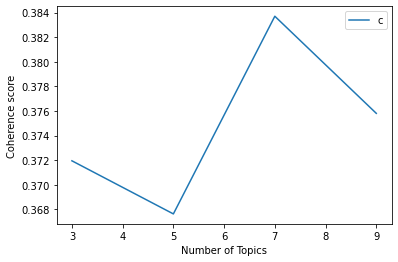

In [36]:
# the plot shows that the number of topics based on coherence score
x = range(3, 10, 2)
plt.plot(x, lda_models[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Define LDA function for chunksize = 1500 with passes = 30
def compute_lda_coherence_scores (id2word, texts, corpus, stop, start, step):
  
  """
  Input:  id2word: a dictionary that maps token ID to tokens
          texts: a list of list strings
          corpus: Gensim corpus which is a BOW model with bigrams
          stop: Max number of topics 
          start: Min number of topics
          step: number of topics to increment 
  Output: model_list: a list of LDA topic models 
          coherence_score: a list of coherence scores for each topic model
  """
  coherence_score = []
  model_list = []

  for n_topics in range (start, stop, step):
    chunksize = 1500
    passes = 30
    iterations = 400 # we increase its iterations
    eval_every = None  # 
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)
    
    model_list.append(lda_model)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    coherence_score.append(coherence_model_lda.get_coherence())
    print('Done')

  return model_list, coherence_score

In [38]:
# run the model
%time lda_models_pass20 = compute_lda_coherence_scores (id2word, texts, corpus, stop=10, start=3, step=2)

Done


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Done


Done
Done
CPU times: user 45min 50s, sys: 31.7 s, total: 46min 22s
Wall time: 46min 21s


In [39]:
lda_models_pass20[1]

[0.41304063139201536,
 0.37203027476281114,
 0.4331259123303442,
 0.4471559798803454]

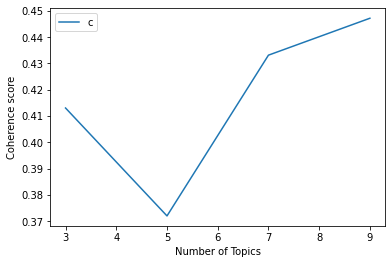

In [40]:
# the plot shows that the number of topics based on coherence score
x = range(3, 10, 2)
plt.plot(x, lda_models_pass20[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# Define LDA function for chunksize = 1500 with passes = 20
def compute_lda_coherence_scores (id2word, texts, corpus, stop, start, step):
  
  """
  Input:  id2word: a dictionary that maps token ID to tokens
          texts: a list of list strings
          corpus: Gensim corpus which is a BOW model with bigrams
          stop: Max number of topics 
          start: Min number of topics
          step: number of topics to increment 
  Output: model_list: a list of LDA topic models 
          coherence_score: a list of coherence scores for each topic model
  """
  coherence_score = []
  model_list = []

  for n_topics in range (start, stop, step):
    chunksize = 1500
    passes = 20
    iterations = 400 # we increase its iterations
    eval_every = None  # 
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)
    
    model_list.append(lda_model)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    coherence_score.append(coherence_model_lda.get_coherence())
    print('Done')

  return model_list, coherence_score

In [42]:
# run the model
%time lda_models_pass = compute_lda_coherence_scores (id2word, texts, corpus, stop=10, start=3, step=2)

Done


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Done


Done
Done
CPU times: user 35min 9s, sys: 24.9 s, total: 35min 34s
Wall time: 35min 33s


In [43]:
lda_models_pass[1]

[0.41284058986591915,
 0.3701487437068371,
 0.4222927586839109,
 0.445355684916928]

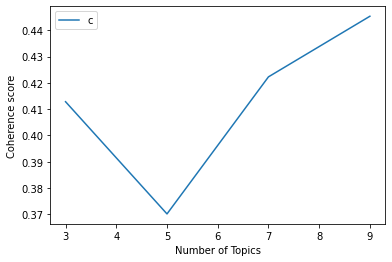

In [44]:
# the plot shows that the number of topics based on coherence score
x = range(3, 10, 2)
plt.plot(x, lda_models_pass[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

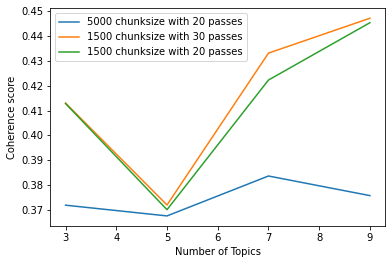

In [45]:
# compare the coherence socre for three hyperparameter set
x = range(3, 10, 2)
plt.plot(x, lda_models[1])
plt.plot(x, lda_models_pass20[1])
plt.plot(x, lda_models_pass[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("5000 chunksize with 20 passes", "1500 chunksize with 30 passes", "1500 chunksize with 20 passes"), loc='best')
plt.show()

From the plot above, we can see the LDA model with chunksize = 1500 and passes = 30 has a higher coherence score on any number of topics than the other two models. However, the training time for the model is 46 minutes and 10 more minutes than the training process of the model with chunksize = 1500 and passes = 20. Besides, the model with chunksize = 1500 and passes = 20 just has slight drops in the score for each number of topics than the one with chunksize = 1500 and passes = 30. As a result, after evaluating the tradeoff between coherence score and training time, we decide to use the model with chunksize = 1500 and passes = 20 in our project.

## Evaluate the best topics numbers for LDA model

In [ ]:
# Define LDA function for chunksize = 1500 with passes = 20
def compute_lda_coherence_scores (id2word, texts, corpus, stop, start, step):
  
  """
  Input:  id2word: a dictionary that maps token ID to tokens
          texts: a list of list strings
          corpus: Gensim corpus which is a BOW model with bigrams
          stop: Max number of topics 
          start: Min number of topics
          step: number of topics to increment 
  Output: model_list: a list of LDA topic models 
          coherence_score: a list of coherence scores for each topic model
  """
  coherence_score = []
  model_list = []

  for n_topics in range (start, stop, step):
    chunksize = 1500
    passes = 20
    iterations = 400 # we increase its iterations
    eval_every = None  # 
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)
    
    model_list.append(lda_model)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    coherence_score.append(coherence_model_lda.get_coherence())
    print('Done')

  return model_list, coherence_score

In [46]:
# run the model
%time lda_models_final = compute_lda_coherence_scores (id2word, texts, corpus, stop=18, start=3, step=2)

Done


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Done


Done
Done
Done
Done
Done
Done
CPU times: user 1h 6min 35s, sys: 41.3 s, total: 1h 7min 17s
Wall time: 1h 7min 15s


In [47]:
lda_models_final[1]

[0.41284058986591915,
 0.3701487437068371,
 0.4222927586839109,
 0.445355684916928,
 0.44507797406715094,
 0.4349106184571582,
 0.4071825498533624,
 0.39758966554189007]

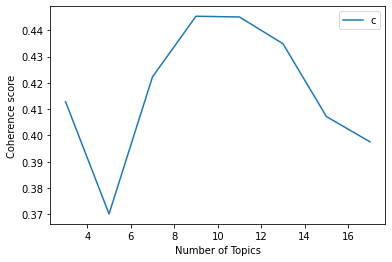

In [48]:
# the plot shows that the number of topics based on coherence score may be between 9 to 11. 
x = range(3, 18, 2)
plt.plot(x, lda_models_final[1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# 9 topics LDA model

num_topics = 9
chunksize = 1500
passes = 20
iterations = 400
eval_every = None  

# train LDA model 
import time 
start = time.time()

lda_model_9 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)

print('training time in second', (time.time() - start))

training time in second 432.86808681488037


In [42]:
# default print topic
# we can see the topic is much easier to interpret, partly because of LAD algroithm, partly because we filtered extreme words
for index, value in lda_model_9.print_topics():
  print('Topic ', index, ':', value)

Topic  0 : 0.086*"staff" + 0.042*"great" + 0.030*"nice" + 0.026*"care" + 0.026*"always" + 0.026*"experience" + 0.025*"friendly" + 0.022*"professional" + 0.020*"best" + 0.020*"thank"
Topic  1 : 0.083*"doctor" + 0.048*"patient" + 0.040*"care" + 0.038*"time" + 0.037*"see" + 0.019*"visit" + 0.019*"take" + 0.018*"need" + 0.017*"medical" + 0.015*"office"
Topic  2 : 0.036*"get" + 0.027*"say" + 0.026*"would" + 0.023*"come" + 0.021*"place" + 0.020*"tell" + 0.018*"one" + 0.018*"take" + 0.018*"give" + 0.017*"nurse"
Topic  3 : 0.192*"insurance" + 0.160*"pay" + 0.113*"kaiser" + 0.081*"charge" + 0.080*"bill" + 0.034*"money" + 0.033*"service" + 0.033*"cost" + 0.030*"company" + 0.030*"billing"
Topic  4 : 0.208*"son" + 0.182*"daughter" + 0.107*"baby" + 0.105*"child" + 0.086*"kid" + 0.082*"wife" + 0.033*"year_old" + 0.024*"pregnancy" + 0.023*"pediatrician" + 0.023*"parent"
Topic  5 : 0.259*"pain" + 0.127*"surgery" + 0.099*"ray" + 0.045*"injury" + 0.044*"foot" + 0.036*"discharge" + 0.029*"remove" + 0.028

In [43]:
# let's visualize the result using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_9, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.219435 -0.033056       1        1  39.958003
1     -0.175445 -0.007046       2        1  21.894618
0     -0.140119 -0.066591       3        1  13.688574
8     -0.141494  0.060121       4        1  11.660500
6     -0.143679 -0.066317       5        1   6.843738
5      0.163890  0.122198       6        1   1.787965
4      0.283722 -0.362775       7        1   1.622369
3      0.176927  0.272165       8        1   1.547280
7      0.195633  0.081300       9        1   0.996953, topic_info=                     Term          Freq         Total Category  logprob  \
158                  wait  26978.000000  26978.000000  Default  30.0000   
39                   call  30917.000000  30917.000000  Default  29.0000   
47                 doctor  42291.000000  42291.000000  Default  28.0000   
83                  staff  28629.000000  28629.000000  Default  27.0000   
294                  pain  10671.000000  10671.000000  Default  26.0000   
98                   hour  15314.000000  15314.000000  Default  25.0000   
29                   time  35341.000000  35341.000000  Default  24.0000   
626           urgent_care  14610.000000  14610.000000  Default  23.0000   
54                    get  43275.000000  43275.000000  Default  22.0000   
144               patient  24403.000000  24403.000000  Default  21.0000   
78                    see  28089.000000  28089.000000  Default  20.0000   
471                   son   7767.000000   7767.000000  Default  19.0000   
130                  tell  28678.000000  28678.000000  Default  18.0000   
35            appointment  15726.000000  15726.000000  Default  17.0000   
14                   care  28559.000000  28559.000000  Default  16.0000   
139                  look   8670.000000   8670.000000  Default  15.0000   
345             insurance   6828.000000   6828.000000  Default  14.0000   
502              daughter   6790.000000   6790.000000  Default  13.0000   
55                  great  13378.000000  13378.000000  Default  12.0000   
168                  room   9290.000000   9290.000000  Default  11.0000   
176                  come  24383.000000  24383.000000  Default  10.0000   
182                   pay   5700.000000   5700.000000  Default   9.0000   
46                    day  14666.000000  14666.000000  Default   8.0000   
240               surgery   5233.000000   5233.000000  Default   7.0000   
86              treatment   5284.000000   5284.000000  Default   6.0000   
146               service   8666.000000   8666.000000  Default   5.0000   
76                    say  27596.000000  27596.000000  Default   4.0000   
38                   back  21929.000000  21929.000000  Default   3.0000   
253                 visit  10743.000000  10743.000000  Default   2.0000   
424                  nice   9675.000000   9675.000000  Default   1.0000   
11                    bad  11610.992805  11611.143291   Topic1  -4.3730   
75                   rude   7391.364497   7391.546272   Topic1  -4.8247   
229              horrible   5045.798578   5045.943969   Topic1  -5.2064   
84                   talk   4855.912273   4856.077592   Topic1  -5.2448   
174              anything   4113.061577   4113.209516   Topic1  -5.4108   
230                   let   3489.616897   3489.760277   Topic1  -5.5752   
238             something   3648.695819   3648.846580   Topic1  -5.5306   
37               attitude   2317.288541   2317.429918   Topic1  -5.9846   
278                 woman   2444.690096   2444.843957   Topic1  -5.9311   
44                  covid   2174.104459   2174.253475   Topic1  -6.0484   
256                  away   2209.551328   2209.711625   Topic1  -6.0322   
499        emergency_room   1899.179832   1899.319989   Topic1  -6.1836   
520                  joke   1832.673094   1832.814539   Topic1  -6.2192   
476             literally   1989.583378   1989.738735   Topic1 

In [44]:
# 11 topics LDA model

num_topics = 11
chunksize = 1500
passes = 20
iterations = 400
eval_every = None  

# train LDA model 
import time 
start = time.time()

lda_model_11 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)

print('training time in second', (time.time() - start))

training time in second 405.8073732852936


In [45]:
# default print topic
# we can see the topic is much easier to interpret, partly because of LAD algroithm, partly because we filtered extreme words
for index, value in lda_model_11.print_topics():
  print('Topic ', index, ':', value)

Topic  0 : 0.090*"staff" + 0.043*"great" + 0.031*"nice" + 0.029*"care" + 0.027*"experience" + 0.027*"always" + 0.025*"friendly" + 0.022*"professional" + 0.020*"best" + 0.020*"thank"
Topic  1 : 0.078*"doctor" + 0.047*"time" + 0.045*"patient" + 0.037*"see" + 0.036*"care" + 0.021*"take" + 0.019*"visit" + 0.018*"need" + 0.016*"medical" + 0.015*"find"
Topic  2 : 0.040*"get" + 0.030*"say" + 0.030*"would" + 0.025*"come" + 0.023*"tell" + 0.022*"place" + 0.019*"one" + 0.019*"give" + 0.018*"take" + 0.018*"back"
Topic  3 : 0.412*"pain" + 0.320*"son" + 0.071*"injury" + 0.058*"riverside" + 0.039*"mri" + 0.030*"severe" + 0.023*"arm" + 0.013*"hurt" + 0.009*"cause" + 0.006*"year_old"
Topic  4 : 0.290*"baby" + 0.222*"wife" + 0.089*"ultrasound" + 0.065*"pregnancy" + 0.058*"touch" + 0.056*"deliver" + 0.056*"pregnant" + 0.027*"child" + 0.026*"first" + 0.024*"week"
Topic  5 : 0.254*"hospital" + 0.109*"nurse" + 0.077*"husband" + 0.061*"mom" + 0.044*"mother" + 0.039*"covid" + 0.038*"night" + 0.034*"emergency

In [46]:
# let's visualize the result using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_11, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.245000 -0.058503       1        1  38.495985
1      0.223394 -0.043604       2        1  23.210699
0      0.146881 -0.065753       3        1  13.237081
8      0.163773  0.074319       4        1  10.547535
9      0.129788 -0.086145       5        1   6.158241
5     -0.100356 -0.071572       6        1   2.218257
7     -0.051230  0.209679       7        1   1.569789
6     -0.260691 -0.223186       8        1   1.524689
10    -0.087711  0.317276       9        1   1.351895
3     -0.226394  0.082715      10        1   0.949118
4     -0.182454 -0.135226      11        1   0.736710, topic_info=                     Term          Freq         Total Category  logprob  \
158                  wait  28801.000000  28801.000000  Default  30.0000   
39                   call  30624.000000  30624.000000  Default  29.0000   
47                 doctor  42028.000000  42028.000000  Default  28.0000   
626           urgent_care  13894.000000  13894.000000  Default  27.0000   
83                  staff  28098.000000  28098.000000  Default  26.0000   
374                 nurse  17958.000000  17958.000000  Default  25.0000   
285              hospital  12999.000000  12999.000000  Default  24.0000   
29                   time  36839.000000  36839.000000  Default  23.0000   
98                   hour  16349.000000  16349.000000  Default  22.0000   
294                  pain   9016.000000   9016.000000  Default  21.0000   
54                    get  43216.000000  43216.000000  Default  20.0000   
240               surgery   8389.000000   8389.000000  Default  19.0000   
144               patient  24286.000000  24286.000000  Default  18.0000   
471                   son   6996.000000   6996.000000  Default  17.0000   
78                    see  28845.000000  28845.000000  Default  16.0000   
35            appointment  15459.000000  15459.000000  Default  15.0000   
345             insurance   7079.000000   7079.000000  Default  14.0000   
130                  tell  28444.000000  28444.000000  Default  13.0000   
14                   care  28247.000000  28247.000000  Default  12.0000   
55                  great  13145.000000  13145.000000  Default  11.0000   
182                   pay   5910.000000   5910.000000  Default  10.0000   
97                  first  10496.000000  10496.000000  Default   9.0000   
168                  room   9845.000000   9845.000000  Default   8.0000   
432                  baby   4926.000000   4926.000000  Default   7.0000   
176                  come  25045.000000  25045.000000  Default   6.0000   
46                    day  14958.000000  14958.000000  Default   5.0000   
76                    say  27505.000000  27505.000000  Default   4.0000   
146               service   8762.000000   8762.000000  Default   3.0000   
237             procedure   4794.000000   4794.000000  Default   2.0000   
201                minute   7165.000000   7165.000000  Default   1.0000   
11                    bad  11753.833641  11753.974761   Topic1  -4.3235   
75                   rude   7482.287764   7482.424270   Topic1  -4.7752   
84                   talk   4915.648745   4915.787564   Topic1  -5.1953   
174              anything   4163.659826   4163.795617   Topic1  -5.3613   
65                   name   4238.852358   4239.007039   Topic1  -5.3434   
238             something   3693.581264   3693.719182   Topic1  -5.4811   
354                   put   4422.561568   4422.728734   Topic1  -5.3010   
230                   let   3532.547390   3532.683986   Topic1  -5.5257   
261                  lady   3515.441565   3515.631456   Topic1  -5.5305   
37               attitude   2345.795054   2345.929253   Topic1  -5.9351   
229              horrible   5107.819185   5108.139677   Topic1  -5.1569   
256                  away   2236.730345   2236.876397   Topic1  -5.9827   
514              employee   20

In [36]:
# 10 topics LDA model

num_topics = 10
chunksize = 1500
passes = 20
iterations = 400
eval_every = None  

# train LDA model 
import time 
start = time.time()

lda_model_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=777,
                                            chunksize=chunksize,
                                            passes=passes,
                                            alpha='auto',
                                            eta ='auto',
                                            iterations = iterations,
                                            gamma_threshold=0.001,
                                            per_word_topics=True,
                                            eval_every = eval_every)

print('training time in second', (time.time() - start))

training time in second 416.9612879753113


In [37]:
# default print topic
# we can see the topic is much easier to interpret, partly because of LAD algroithm, partly because we filtered extreme words
for index, value in lda_model_10.print_topics():
  print('Topic ', index, ':', value)

Topic  0 : 0.095*"staff" + 0.052*"great" + 0.047*"care" + 0.032*"always" + 0.031*"experience" + 0.026*"professional" + 0.024*"best" + 0.024*"thank" + 0.023*"kind" + 0.020*"good"
Topic  1 : 0.072*"doctor" + 0.045*"time" + 0.042*"patient" + 0.034*"see" + 0.028*"care" + 0.023*"office" + 0.020*"take" + 0.019*"visit" + 0.018*"need" + 0.014*"medical"
Topic  2 : 0.040*"get" + 0.029*"say" + 0.028*"would" + 0.026*"come" + 0.023*"place" + 0.023*"tell" + 0.019*"back" + 0.019*"one" + 0.018*"give" + 0.018*"take"
Topic  3 : 0.186*"insurance" + 0.176*"son" + 0.155*"pay" + 0.110*"kaiser" + 0.078*"charge" + 0.078*"bill" + 0.032*"cost" + 0.032*"riverside" + 0.026*"cover" + 0.023*"service"
Topic  4 : 0.267*"daughter" + 0.158*"baby" + 0.155*"child" + 0.121*"wife" + 0.055*"year_old" + 0.048*"ultrasound" + 0.035*"pregnancy" + 0.033*"parent" + 0.031*"deliver" + 0.031*"pregnant"
Topic  5 : 0.186*"hospital" + 0.111*"pain" + 0.057*"nurse" + 0.044*"mom" + 0.042*"ray" + 0.032*"mother" + 0.028*"night" + 0.027*"ant

In [38]:
# let's visualize the result using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_10, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.245257  0.003127       1        1  38.667955
1     -0.211999  0.086403       2        1  25.139863
0     -0.083109  0.266220       3        1  11.433521
8     -0.159750 -0.176584       4        1   9.456152
9     -0.118234 -0.048424       5        1   5.767731
5      0.049774 -0.148947       6        1   2.999843
6      0.210525  0.302163       7        1   2.176607
3      0.226014 -0.040653       8        1   1.614624
7      0.066614 -0.124956       9        1   1.573223
4      0.265421 -0.118349      10        1   1.170481, topic_info=                     Term          Freq         Total Category  logprob  \
158                  wait  28887.000000  28887.000000  Default  30.0000   
39                   call  31128.000000  31128.000000  Default  29.0000   
626           urgent_care  14957.000000  14957.000000  Default  28.0000   
47                 doctor  42141.000000  42141.000000  Default  27.0000   
83                  staff  29130.000000  29130.000000  Default  26.0000   
29                   time  37089.000000  37089.000000  Default  25.0000   
98                   hour  16398.000000  16398.000000  Default  24.0000   
285              hospital  12827.000000  12827.000000  Default  23.0000   
374                 nurse  18130.000000  18130.000000  Default  22.0000   
54                    get  42732.000000  42732.000000  Default  21.0000   
14                   care  28604.000000  28604.000000  Default  20.0000   
240               surgery   8246.000000   8246.000000  Default  19.0000   
130                  tell  28305.000000  28305.000000  Default  18.0000   
502              daughter   7210.000000   7210.000000  Default  17.0000   
78                    see  28906.000000  28906.000000  Default  16.0000   
144               patient  24361.000000  24361.000000  Default  15.0000   
35            appointment  15327.000000  15327.000000  Default  14.0000   
55                  great  13614.000000  13614.000000  Default  13.0000   
345             insurance   6928.000000   6928.000000  Default  12.0000   
471                   son   6530.000000   6530.000000  Default  11.0000   
424                  nice   7032.000000   7032.000000  Default  10.0000   
294                  pain   7667.000000   7667.000000  Default   9.0000   
168                  room   9861.000000   9861.000000  Default   8.0000   
182                   pay   5784.000000   5784.000000  Default   7.0000   
46                    day  14934.000000  14934.000000  Default   6.0000   
176                  come  24977.000000  24977.000000  Default   5.0000   
200              friendly   5669.000000   5669.000000  Default   4.0000   
38                   back  21675.000000  21675.000000  Default   3.0000   
201                minute   7206.000000   7206.000000  Default   2.0000   
76                    say  27343.000000  27343.000000  Default   1.0000   
11                    bad  11658.124203  11658.282632   Topic1  -4.3362   
75                   rude   7421.362113   7421.498539   Topic1  -4.7878   
84                   talk   4875.621173   4875.764623   Topic1  -5.2079   
174              anything   4129.754732   4129.891713   Topic1  -5.3739   
230                   let   3503.783572   3503.922032   Topic1  -5.5383   
238             something   3663.507055   3663.657900   Topic1  -5.4937   
261                  lady   3486.813725   3486.964874   Topic1  -5.5432   
65                   name   4204.341086   4204.582997   Topic1  -5.3560   
37               attitude   2326.694550   2326.828544   Topic1  -5.9477   
514              employee   2045.950560   2046.087284   Topic1  -6.0763   
558                   ear   1786.843872   1786.977232   Topic1  -6.2117   
307            waste_time   1630.732933   1630.866219   Topic1  -6.3031   
545                 worst   1536.065925   1536.198733   Topic1  -6.3629   
574      

### Discussion of the best model of LDA
The coherence score plot shows that 9 topics and 11 topics have the highest score among others. Therefore, we analyze these two topic models as well as 10 topic models to further understand their topic qualities. From their visualizations, there are some common topics three models can find out easily. However, for some topics in 10 topics LDA model and 11 topics LDA model, there are some noisy words in those topics. For example, the 8th topic in the 10 topics model shows "insurance", "pay", and "kaiser" with "son" and "riverside". It does not show a clear pattern for medical insurance. It shows a similar issue for the 10th topic in the 11 topics models. The topic has "pain", "injury", and "mri" with "son" and "riverside". These words can not reflect a clear topic for injury detection. On the other hand, topics in 9 topic model are clearer and can be identified immediately. Also, they have fewer noisy words. As a result, we choose 9 topics LDA model as the best model for topic modeling. Later, we will use the model to calculate the topic distribution of each review. Then we would aggregate the database on each business and use the average topic distribution as their topic vector.

### Lables for each topic
 - Topic 1: General Experience
 - Topic 2: Doctor Visit
 - Topic 3: Staff
 - Topic 4: Appointment
 - Topic 5: Urgent Care Waiting Time
 - Topic 6: Surgery
 - Topic 7: Maternity Care
 - Topic 8: Medical Insurance
 - Topic 9: Medical Care Consultation

## Topic Vector for Business

In [102]:
# Create the first dataframe for topic distribution of first review
lda_model_9.get_document_topics([corpus[0]], 0, per_word_topics=True) # set minium value
test = lda_model_9[corpus[0]] # topic distribution
df_topicvec = pd.DataFrame(test, columns = ['0', '1']).drop(['0'], axis =1).T
df_topicvec

,0,1,2,3,4,5,6,7,8
1,0.317835,0.283818,0.264632,0.007889,0.008413,0.008747,0.057324,0.005112,0.046231


In [103]:
# Calculate topic distribution for each review
for i in range(1, len(corpus)):
  df_topicvec = pd.concat([df_topicvec, pd.DataFrame(lda_model_9[corpus[i]], columns = ['0', '1']).drop(['0'], axis =1).T])
df_topicvec

,0,1,2,3,4,5,6,7,8
1,0.317835,0.283818,0.264632,0.007889,0.008413,0.008747,0.057324,0.005112,0.046231
1,0.053570,0.390080,0.426184,0.003275,0.003479,0.003618,0.021052,0.002115,0.096629
1,0.090256,0.258356,0.421139,0.001773,0.001890,0.001966,0.010441,0.001149,0.213030
1,0.052719,0.135535,0.373817,0.002685,0.002864,0.002980,0.113493,0.001740,0.314169
1,0.044419,0.152564,0.633663,0.003960,0.004222,0.004395,0.024277,0.002565,0.129936
...,...,...,...,...,...,...,...,...,...
1,0.303911,0.201390,0.327735,0.004266,0.004552,0.004728,0.088470,0.036152,0.028795
1,0.105523,0.452473,0.267626,0.004056,0.004324,0.004503,0.074538,0.002628,0.084328
1,0.362056,0.214083,0.262682,0.002972,0.003198,0.023892,0.109183,0.001926,0.020007
1,0.120564,0.181405,0.452985,0.004513,0.031763,0.004998,0.163678,0.002911,0.037182


In [114]:
# Put Column Names
df_topicvec.columns = ['TD1', 'TD2', 'TD3', 'TD4', 'TD5', 'TD6', 'TD7', 'TD8', 'TD9']
df_topicvec.reset_index(inplace = True, drop = True)
df_topicvec.head()

,TD1,TD2,TD3,TD4,TD5,TD6,TD7,TD8,TD9
0,0.317835,0.283818,0.264632,0.007889,0.008413,0.008747,0.057324,0.005112,0.046231
1,0.053570,0.390080,0.426184,0.003275,0.003479,0.003618,0.021052,0.002115,0.096629
2,0.090256,0.258356,0.421139,0.001773,0.001890,0.001966,0.010441,0.001149,0.213030
3,0.052719,0.135535,0.373817,0.002685,0.002864,0.002980,0.113493,0.001740,0.314169
4,0.044419,0.152564,0.633663,0.003960,0.004222,0.004395,0.024277,0.002565,0.129936


In [115]:
# merge join with the original dataset
df_top2vec = pd.concat([df, df_topicvec], axis = 1)
df_top2vec.head(3)

,username,rating_x,date_of_review,review_content,rounded_rating,doctorID,Business ID,Name,Business Category,URL,snippet text,Address,City,State code,zip code,clamed,closed,latitude,longitude,phone_x,review_expanded,review_token,Potential_misspells,review_tagged,review_lemmas,review_norm,cleaned_review,Review_Length,unique_token,Cleaned_Review_Length,Lexical_Diversity,Count_Potential_Misspells,messageID,best,guy,check,!!!,many,year,always,recommend,team,thanks,doc,review,think,business,however,big,stop,care,...,client,response,rating_y,good,even,take,time,write,experience,address,bad,leave,much,high,make,issue,couple,real,ever,since,covid,medical,initial,appointment,staff,rude,find,practice,possible,information,phone_y,zero,compassion,try,end,conversation,thank,hope,day,hang,call,back,get,name,speak,office,manager,say,way,know,also,attitude,may,person,talk,set,schedule,email,ask,date,birth,cancel,kind,treatment,allow,see,forget,seriously,concern,health,anyone,field,anymore,side,note,respond,positive,door,great,doctor,never,show,minute,early,could,quickly,return,work,sign,sit,almost,two,hour,seem,admit,miss,file,add,short,next,another,watch,multiple,people,ahead,saw,want,order,test,need,first,week,later,would,three,month,ago,still,nothing,doctors,story,help,dad,tell,turn,like,stay,reschedule,meet,beyond,location,easy,clean,treat,respect,service,warm,patient,professional,extremely,knowledgeable,look,change,explain,negative,past,either,super,maybe,welcome,highly,sure,someone,long,wait,run,behind,mention,wear,require,one,awesome,face,surprise,non,soon,room,fill,decide,uncomfortable,car,ready,inside,inform,though,cost,bother,come,anything,reason,star,everything,else,knowledge,etc,actually,insurance,company,pay,man,pain,several,different,medicine,finally,able,figure,prescribe,right,feel,thankful,around,top,friendly,appt,felt,really,situation,prescription,refer,friend,immediately,comfortable,everyone,walk,compassionate,well,happy,book,simple,process,share,complaint,horrible,definitely,mother,perform,complete,procedure,mom,something,happen,let,hard,believe,cause,front,prior,surgery,place,guess,post,comment,bit,nervous,forever,arrive,mind,condition,base,type,question,along,plan,send,smile,receive,follow,appreciate,visit,give,hear,lady,away,unprofessional,cannot,answer,open,family,father,exam,thorough,far,expect,obviously,listen,medication,word,wonderful,bedside,manner,woman,desk,god,others,especially,poor,new,completely,husband,message,regard,specialist,special,plus,wrong,job,level,....,lobby,hospital,seek,yes,life,young,glass,wow,today,suck,yet,pretty,without,detail,suppose,history,previous,waste,truly,small,learn,quite,due,course,price,please,read,must,stick,honestly,switch,second,thing,twice,cancer,report,paper,use,hand,five,voice,full,claim,system,update,record,put,hold,contact,tech,assistant,keep,pleasant,bed,problem,skill,customer,elsewhere,lose,money,incompetent,till,state,pharmacy,pleased,instead,scan,request,wonder,ridiculous,busy,facility,save,heart,reach,age,primary,physician,consultation,online,bring,physical,pick,actual,efficient,nurse,consider,wife,part,remove,single,recovery,available,serious,quick,healthy,old,little,four,last,half,okay,fact,agree,unfortunately,case,understanding,lie,san,bill,provide,proper,sorry,handle,lunch,break,less,spend,anywhere,polite,courteous,area,worth,impressed,understand,choice,paperwork,min,least,notice,proceed,basically,drive,charge,point,billing,advise,member,honest,probably,every,helpful,nice,receptionist,surgeon,cold,together,pregnant,blood,pressure,clinic,apparently,already,start,water,grateful,child,sweet,informative,overall,trust,deliver,baby,emergency,necessary,waiting,result,chest,home,awful,move,labor,delivery,whole,amazing,ease,shot,remember,night,extra,offer,amaze,world,girl,matter,beautiful,floor,ultrasound,close,department,ray,within,machine,son,total,huge,avoid,stuff,literally,pass,straight,choose,number,loved,suffer,list,diagnose,school,include,sometimes,ignore,continue,longer

In [117]:
# Calculate mean vector for each Business
df_business = df_top2vec.loc[:, ['Business ID ', 'rounded_rating', 'TD1', 'TD2', 'TD3', 'TD4', 'TD5', 'TD6', 'TD7', 'TD8', 'TD9']].copy().groupby('Business ID ').mean().reset_index()
df_business.head()

,Business ID,rounded_rating,TD1,TD2,TD3,TD4,TD5,TD6,TD7,TD8,TD9
0,24-7-care-at-home-westminster-2,5.0,0.297569,0.254693,0.335467,0.004712,0.005008,0.008364,0.032568,0.003042,0.058577
1,4-ever-green-collective-riverside,5.0,0.219003,0.170542,0.439515,0.007690,0.007584,0.007888,0.063191,0.014732,0.069855
2,a-doctors-weight-loss-clinic-moreno-valley-2,4.5,0.247202,0.183562,0.377233,0.009746,0.008352,0.007634,0.072140,0.014723,0.079408
3,a-gobaud-orthopaedic-medical-clnc-and-bck-trtm...,1.0,0.080379,0.284567,0.318722,0.008281,0.008831,0.009181,0.042936,0.005365,0.241737
4,a-healing-within-palm-desert,4.0,0.208102,0.241902,0.370235,0.015115,0.007527,0.012299,0.058872,0.032510,0.053438


In [118]:
# Save the topic vector file
df_business.to_csv('/content/drive/MyDrive/Colab Notebooks/Mydata/business_topicvector.csv')